In [ ]:
%pip install tensorflow


In [2]:
%pip install numpy
%pip install matplotlib
%pip install scikit-learn
%pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install keras

Note: you may need to restart the kernel to use updated packages.


# Data loading and Pre- Processing

In [17]:
# Housekeeping
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image


In [26]:
#defining the dataset path and directories
base_path = 'dataset/chest_xray'
dir_train = os.path.join(base_path, 'train')
dir_val = os.path.join(base_path, 'val')
dir_test = os.path.join(base_path, 'test')


In [27]:
# Function to remove corrupted images
def remove_corrupted_images(directory):
    removed_files = []
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(subdir, file)
            try:
                with Image.open(filepath) as img:
                    img.verify()  # Verify if the image is corrupted
            except (IOError, SyntaxError):
                os.remove(filepath)  # Remove the corrupted image
                removed_files.append(filepath)

    return removed_files


In [28]:
# Removing corrupted images from each directory
remove_corrupted_images(dir_train)
remove_corrupted_images(dir_val)
remove_corrupted_images(dir_test)

[]

In [29]:
# Image data generator with augmentation for training
train_dataGen = ImageDataGenerator(
    rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
    zoom_range=0.2, horizontal_flip=True)


In [30]:
# Image data generator without augmentation for validation and testing
test_dataGen = ImageDataGenerator(rescale=1./255)

In [31]:
# Loading images from the directories
train_Gen = train_dataGen.flow_from_directory(dir_train, target_size=(150,150), batch_size=20, class_mode='binary')
valid_Gen = test_dataGen.flow_from_directory(dir_val, target_size=(150,150), batch_size=20, class_mode='binary')
test_Gen = test_dataGen.flow_from_directory(dir_test, target_size=(150,150), batch_size=20, class_mode='binary')


Found 5215 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [32]:
# Import necessary components to build the model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

In [33]:
# Function to create the model based on InceptionV3
def create_inception_model():
    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(150, 150, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)  # Add a new fully connected layer
    predictions = Dense(1, activation='sigmoid')(x)  # Final layer with sigmoid activation for binary classification
    
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [34]:
# Create the model
inception_model = create_inception_model()

In [37]:
history_inception = inception_model.fit(train_Gen, epochs=10, validation_data=valid_Gen)

Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 228s 868ms/step - accuracy: 0.8806 - loss: 0.3307 - val_accuracy: 0.6875 - val_loss: 0.9875
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 242s 923ms/step - accuracy: 0.9303 - loss: 0.1829 - val_accuracy: 0.5625 - val_loss: 1.9875
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 251s 958ms/step - accuracy: 0.9371 - loss: 0.1748 - val_accuracy: 0.6875 - val_loss: 0.7030
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.9321 - loss: 0.1850 - val_accuracy: 0.8750 - val_loss: 0.2807
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 305s 1s/step - accuracy: 0.9453 - loss: 0.1396 - val_accuracy: 0.7500 - val_loss: 0.5204
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.9549 - loss: 0.1258 - val_accuracy: 0.7500 - val_loss: 0.4611
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.9612 - loss: 0.1140 - val_accuracy: 0.5000 - val_loss: 1.4179
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 259s 987ms/step - accuracy: 0.9644 - loss: 0.101

In [38]:
#Training

# Example for GoogleLeNet
#history_inception = inception_model.fit(train_generator, epochs=10, validation_data=validation_generator)


In [40]:
#Evaluation
inception_eval = inception_model.evaluate(test_Gen)


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - accuracy: 0.7976 - loss: 26.4610


In [44]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score


In [45]:
# Predicting from the test generator (without labels)
test_Gen.reset()
predictions = inception_model.predict(test_Gen, steps=len(test_Gen))
# Convert predictions to binary values (0 and 1)
predicted_classes = np.where(predictions > 0.5, 1, 0)

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step


In [46]:
# Retrieve the true labels
true_classes = test_Gen.classes

In [47]:
# Calculate accuracy, precision, and recall
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Accuracy: 0.483974358974359
Precision: 0.6156462585034014
Recall: 0.4641025641025641


In [48]:
import time

# Measure training time
start_time = time.time()
history_inception = inception_model.fit(train_Gen, epochs=10, validation_data=valid_Gen)
training_time = time.time() - start_time

# Measure inference time
start_time = time.time()
inception_model.evaluate(test_Gen)
inference_time = time.time() - start_time

print(f'Training time: {training_time} seconds')
print(f'Inference time: {inference_time} seconds')


Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 222s 847ms/step - accuracy: 0.9631 - loss: 0.1196 - val_accuracy: 0.8750 - val_loss: 0.2779
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 246s 937ms/step - accuracy: 0.9542 - loss: 0.1145 - val_accuracy: 1.0000 - val_loss: 0.1541
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 254s 970ms/step - accuracy: 0.9727 - loss: 0.0750 - val_accuracy: 0.9375 - val_loss: 0.2098
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 256s 975ms/step - accuracy: 0.9568 - loss: 0.1241 - val_accuracy: 0.6875 - val_loss: 1.1511
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.9610 - loss: 0.1111 - val_accuracy: 0.7500 - val_loss: 0.5221
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - accuracy: 0.9689 - loss: 0.0968 - val_accuracy: 0.9375 - val_loss: 0.2788
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - accuracy: 0.9727 - loss: 0.0865 - val_accuracy: 0.8750 - val_loss: 0.2060
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - accuracy: 0.9668 - loss: 0.082

In [49]:
inception_model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_188 (Conv2D) │ (None, 74, 74,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │         96 │ conv2d_188[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_188      │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_189 (Conv2D) │ (None, 72, 72,    │      9,216 │ activation_188[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_189[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_189      │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_190 (Conv2D) │ (None, 72, 72,    │     18,432 │ activation_189[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_190[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_190      │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 35, 35,    │          0 │ activation_190[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_191 (Conv2D) │ (None, 35, 35,    │      5,120 │ max_pooling2d_8[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_191[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_191      │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_192 (Conv2D) │ (None, 33, 33,    │    138,240 │ activation_191[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_192[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_192      │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 68,488,293 (261.26 MB)

 Trainable params: 22,817,953 (87.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

 Optimizer params: 45,635,908 (174.09 MB)

In [52]:
from tensorflow.keras.optimizers import Adam, SGD

# Example hyperparameters to iterate over
learning_rates = [0.001, 0.0001]
optimizers = [Adam, SGD]

for lr in learning_rates:
    for opt in optimizers:
        optimizer = opt(learning_rate=lr)
        model = create_inception_model()
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        # Assuming you have defined train_Gen and valid_Gen earlier
        model.fit(train_Gen, epochs=5, validation_data=valid_Gen)

        # Evaluate the model on your test set, assumed to be defined as test_Gen
        eval_metrics = model.evaluate(test_Gen)
        print(f"Performance for LR={lr} and Optimizer={opt.__name__}: {eval_metrics}")

Epoch 1/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 233s 837ms/step - accuracy: 0.8618 - loss: 0.3525 - val_accuracy: 0.7500 - val_loss: 0.6078
Epoch 2/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 244s 929ms/step - accuracy: 0.9318 - loss: 0.1855 - val_accuracy: 0.8125 - val_loss: 0.3653
Epoch 3/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 250s 955ms/step - accuracy: 0.9444 - loss: 0.1374 - val_accuracy: 0.6250 - val_loss: 0.8169
Epoch 4/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.9553 - loss: 0.1333 - val_accuracy: 0.6875 - val_loss: 0.9063
Epoch 5/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 291s 1s/step - accuracy: 0.9445 - loss: 0.1531 - val_accuracy: 0.5625 - val_loss: 3.5798
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 281ms/step - accuracy: 0.8519 - loss: 2.0328
Performance for LR=0.001 and Optimizer=Adam: [2.2838525772094727, 0.8541666865348816]
Epoch 1/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.7157 - loss: 0.5739 - val_accuracy: 0.6875 - val_loss: 0.5079
Epoch 2/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 398s 2s/step - accuracy

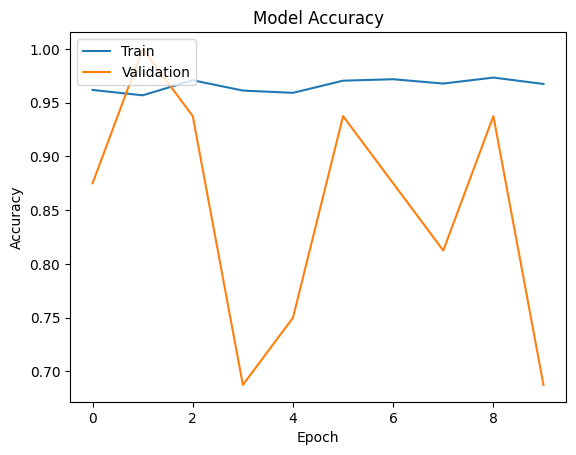

In [53]:
import matplotlib.pyplot as plt

#plots of training and Validation accuracy

plt.plot(history_inception.history['accuracy'])
plt.plot(history_inception.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

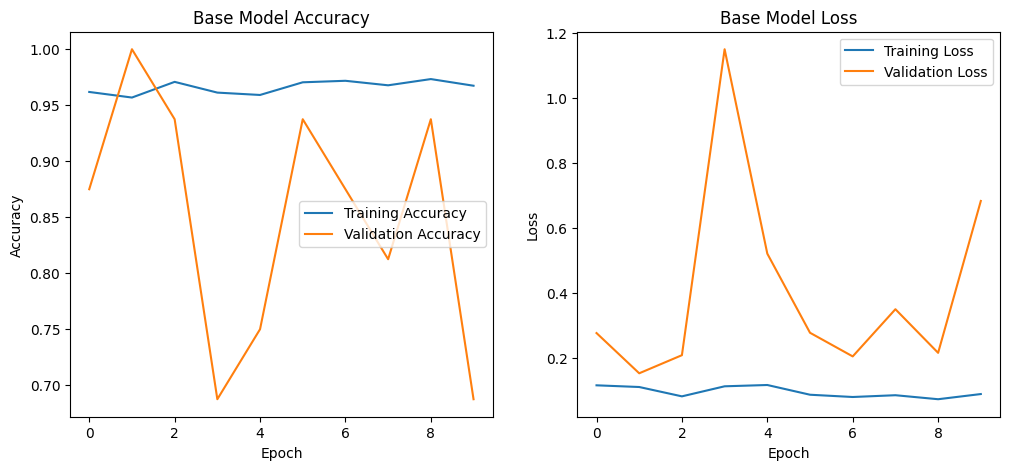

In [54]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_inception.history['accuracy'], label='Training Accuracy')
plt.plot(history_inception.history['val_accuracy'], label='Validation Accuracy')
plt.title('Base Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_inception.history['loss'], label='Training Loss')
plt.plot(history_inception.history['val_loss'], label='Validation Loss')
plt.title('Base Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()